In [1]:
%matplotlib inline

from os.path import join as pjoin
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import patheffects
pe = patheffects.withStroke(foreground="white", linewidth=5)


In [5]:
BASEDIR = r"X:\georisk\HaRIA_B_Wind\data\derived\obs\1-minute\events"
DATADIR = r"X:\georisk\HaRIA_B_Wind\data\derived\obs\1-minute\events-60"
eventFile = pjoin(BASEDIR, "CA_20230518_Hobart.csv")
#eventFile = pjoin(BASEDIR, "NA_all.csv")
#stormdf = pd.read_csv(eventFile, usecols=[2, 3, 4], parse_dates=['date'],
#                dtype={'stnNum': float,
#                       'stormType': 'category'},
#                converters={'stnNum': lambda s: int(float(s.strip() or 0))})

stormdf = pd.read_csv(eventFile, usecols=[1, 2, 3],
                      parse_dates=['date'],
                      dtype={'stnNum': int,
                             'stormType': 'category'},)

<Axes: >

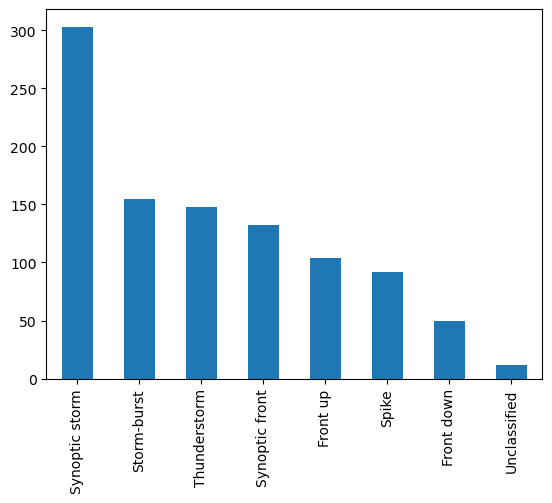

In [4]:
stormdf.stormType.value_counts().plot(kind='bar')

In [6]:
def loadData(stnNum):
    fname = pjoin(DATADIR, "events", f"{stnNum:06d}.pkl")
    df = pd.read_pickle(fname)
    df['date'] = pd.to_datetime(df['date'])
    df['stnNum'] = stnNum
    df.reset_index(inplace=True)
    df.set_index(['stnNum', 'date'], inplace=True)
    return df

In [7]:
stndf = pd.read_csv(pjoin(BASEDIR, 'hqstations.csv'), index_col="stnNum")

Load all the observed data, for all HQ stations and concatenate into a single dataframe. We then create a new attribute (called `idx`) that is a tuple of the MultiIndex of the dataframe (based on station and date)

In [8]:
dflist = []
for stn in stndf.index:
    df = loadData(stn)
    dflist.append(df)

alldf = pd.concat(dflist)
alldf['idx'] = alldf.index

FileNotFoundError: [Errno 2] No such file or directory: 'X:\\georisk\\HaRIA_B_Wind\\data\\derived\\obs\\1-minute\\events-60\\events\\085072.pkl'

We create a similar attribute in the list of storm types...

In [ ]:
stormdf['idx'] = stormdf[['stnNum', 'date']].apply(tuple, axis=1)

synidx = stormdf[stormdf['stormType']=="Synoptic storm"]['idx']
syfidx = stormdf[stormdf['stormType']=="Synoptic front"]['idx']
sbidx = stormdf[stormdf['stormType']=="Storm-burst"]['idx']

tsidx = stormdf[stormdf['stormType']=="Thunderstorm"]['idx']
fuidx = stormdf[stormdf['stormType']=="Front up"]['idx']
fdidx = stormdf[stormdf['stormType']=="Front down"]['idx']

ucidx = stormdf[stormdf['stormType']=="Unclassified"]['idx']
spidx = stormdf[stormdf['stormType']=="Spike"]['idx']


Then we can select the time series of each event that is classified as the selected storm type. We then group by the time difference (i.e. the time before/after the peak gust) and take the mean of all the values. 

In [ ]:
synevents = alldf[alldf.idx.isin(synidx.values)]
syfevents = alldf[alldf.idx.isin(syfidx.values)]
sbevents = alldf[alldf.idx.isin(sbidx.values)]


tsevents = alldf[alldf.idx.isin(tsidx.values)]
fuevents = alldf[alldf.idx.isin(fuidx.values)]
fdevents = alldf[alldf.idx.isin(fdidx.values)]

ucevents = alldf[alldf.idx.isin(ucidx.values)]
spevents = alldf[alldf.idx.isin(spidx.values)]

meansyn = synevents.reset_index().groupby('tdiff').mean().reset_index()
meansyf = syfevents.reset_index().groupby('tdiff').mean().reset_index()
meansb = sbevents.reset_index().groupby('tdiff').mean().reset_index()

meants = tsevents.reset_index().groupby('tdiff').mean().reset_index()
meanfu = fuevents.reset_index().groupby('tdiff').mean().reset_index()
meanfd = fdevents.reset_index().groupby('tdiff').mean().reset_index()

meanuc = ucevents.reset_index().groupby('tdiff').mean().reset_index()
meansp = spevents.reset_index().groupby('tdiff').mean().reset_index()

In [ ]:
def plotEvent(df):
    fig, ax = plt.subplots(figsize=(12,8))
    #ax = fig.add_axes([0, 0, 1, 1])
    #ax2 = ax.twinx()
    axt = ax.twinx()
    axp = ax.twinx()
    ax.set_zorder(1)
    ax.patch.set_visible(False)
    axt.plot(df.tdiff, df.tempanom, label=r"Temperature/dewpoint anomaly [$^o$C]",
             color='r', marker='^', markerfacecolor="None", lw=2, path_effects=[pe], zorder=1,
             markevery=5)
    axt.plot(df.tdiff, df.dpanom, color='orangered', marker='.', markerfacecolor="None",
             lw=1, path_effects=[pe], zorder=1, markevery=5)
    
    ax.plot(df.tdiff, df.windgust, label="Wind gust ['km/h']", 
            lw=3, path_effects=[pe], markerfacecolor="None",zorder=100)
    axp.plot(df.tdiff, df.stnpanom, color='purple', lw=2, path_effects=[pe],
             ls='--', label='Station pressure anomaly [hPa]')


    #axt.spines['right'].set_position(("axes", 1.075))
    axt.spines[['right']].set_color('r')
    axt.yaxis.label.set_color('r')
    axt.tick_params(axis='y', colors='r')
    axt.set_ylabel(r"Temperature/dewpoint anomaly [$^o$C]")

    ax.set_ylabel("Gust wind speed [km/h]")

    axp.spines[['right']].set_position(('axes', 1.075))
    axp.spines[['right']].set_color('purple')
    axp.yaxis.label.set_color('purple')
    axp.tick_params(axis='y', colors='purple')
    axp.set_ylabel("Pressure anomaly [hPa]")

    gmin, gmax = ax.get_ylim()
    pmin, pmax = axp.get_ylim()
    tmin, tmax = axt.get_ylim()
    ax.set_ylim((0, max(gmax, 100)))
    axp.set_ylim((min(-2.0, pmin), max(pmax, 2.0)))
    axt.set_ylim((min(-2.0, tmin), max(tmax, 2.0)))
    #ax2.set_ylim((0, 360))
    #ax2.set_yticks(np.arange(0, 361, 90))
    #axr.set_ylim((0, 100))
    #ax.set_title(meants.index[0])
    ax.grid(True)
    #ax2.grid(False)
    axt.grid(False)
    axp.grid(False)
    #axr.grid(False)

In [ ]:
plotEvent(meants)

In [ ]:
plotEvent(meanfu)

In [ ]:
plotEvent(meanfd)

In [ ]:
plotEvent(meansyn)

In [ ]:
plotEvent(meansyf)

In [ ]:
plotEvent(meansb)

In [ ]:
plotEvent(meansp)

In [ ]:
plotEvent(meanuc)

In [ ]:
def loadGustRatioData(stnNum):
    fname = pjoin(BASEDIR, "gustratio", f"{stnNum:06d}.pkl")
    df = pd.read_pickle(fname)
    df['date'] = pd.to_datetime(df['date'])
    df['stnNum'] = stnNum
    df.reset_index(inplace=True)
    df.set_index(['stnNum', 'date'], inplace=True)
    return df

In [ ]:
grdflist = []
for stn in stndf.index:
    df = loadGustRatioData(stn)
    grdflist.append(df)

allgrdf = pd.concat(grdflist)
allgrdf['idx'] = allgrdf.index

Here we join the manually classified set of events with the automatically classified events (based on the gust ratio). We reset the index of the dataframe holding the manually classified data to match the index of the automatically classified events and provide a suffix to separate the overlapping column names. A cross-tabulation then gives the comparison of events with different classifications. 

In [ ]:
compdf = pd.merge(stormdf.set_index(['stnNum', 'date']), allgrdf, suffixes=('_s', '_g'))

In [ ]:
pd.crosstab(compdf['stormType'], compdf['category'])

In [ ]:
alldf.set_index('tdiff', append=True)[['windgust', 'tempanom', 'stnpanom', 'dpanom']]